# Training and deploying a tabular model using Vertex custom training job

![Training pipeline](../images/custom-tabular.png)

In [3]:
import os
import pprint
import pandas as pd
import tensorflow as tf
import time

import matplotlib.pyplot as plt

from google.cloud import aiplatform as vertex_ai
from google.cloud.aiplatform_v1beta1 import types
from google.cloud import bigquery
from google.cloud import exceptions

from google.cloud.aiplatform.utils import JobClientWithOverride

from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

from tensorflow_io import bigquery as tfio_bq

## Configure GCP settings

*Before running the notebook make sure to follow the repo's README file to install the pre-requisites.*

In [4]:
PROJECT = 'jk-vertex-workshop'
REGION = 'us-central1'
PREFIX = 'jkvw'

STAGING_BUCKET = f'gs://{PREFIX}-bucket'
VERTEX_SA = f'{PREFIX}-training-sa@{PROJECT}.iam.gserviceaccount.com'

TENSORBOARD = 'projects/910094146258/locations/us-central1/tensorboards/6406405654306619392'

## Preparing training data in BigQuery

### Explore Chicago Taxi dataset

In [5]:
%%bigquery data

SELECT 
    *
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
LIMIT 3

Downloading: 100%|██████████| 3/3 [00:01<00:00,  2.53rows/s]


In [6]:
data.head().T

,0,1,2
unique_key,97b1a364c3544d2ca99fe6a43ea433986a972bf4,00d8fcc15a4d99f0efc03595919e0eb348847abf,2cf6a01fbd4d79b3f45554099dd2ccaf324c4baa
taxi_id,01271057890af916c8ee4890c076e44fb6ac327a1868de...,ec73aeaa166a9fabcd546bd176e75ee589e58653db8b0c...,31af69ed89cd6d3c48818cb0ba3541db71149cc4fd3c54...
trip_start_timestamp,2013-09-28 21:30:00+00:00,2013-09-25 14:45:00+00:00,2013-09-25 12:45:00+00:00
trip_end_timestamp,2013-09-28 21:45:00+00:00,2013-09-25 15:00:00+00:00,2013-09-25 13:00:00+00:00
trip_seconds,360,1440,300
trip_miles,0.0,0.0,0.0
pickup_census_tract,NaN,NaN,NaN
dropoff_census_tract,NaN,NaN,NaN
pickup_community_area,NaN,NaN,NaN
dropoff_community_area,NaN,NaN,NaN


In [7]:
%%bigquery data

SELECT 
    CAST(EXTRACT(DAYOFWEEK FROM trip_start_timestamp) AS string) AS trip_dayofweek, 
    FORMAT_DATE('%A',cast(trip_start_timestamp as date)) AS trip_dayname,
    COUNT(*) as trip_count,
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
WHERE
    EXTRACT(YEAR FROM trip_start_timestamp) = 2015 
GROUP BY
    trip_dayofweek,
    trip_dayname
ORDER BY
    trip_dayofweek

Downloading: 100%|██████████| 7/7 [00:01<00:00,  6.32rows/s]


In [8]:
data

,trip_dayofweek,trip_dayname,trip_count
0,1,Sunday,4141154
1,2,Monday,4105900
2,3,Tuesday,4378805
3,4,Wednesday,4542810
4,5,Thursday,4918190
5,6,Friday,5289830
6,7,Saturday,5009186


<AxesSubplot:xlabel='trip_dayname'>

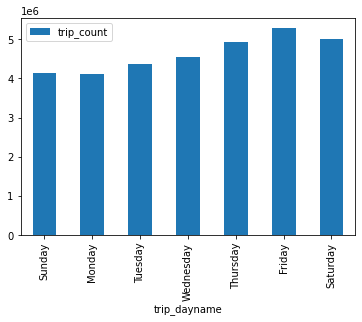

In [9]:
data.plot(kind='bar', x='trip_dayname', y='trip_count')

### Create  data splits

In [10]:
BQ_DATASET_NAME = f'{PREFIX}_dataset' 
BQ_TRAIN_SPLIT_NAME = 'training'
BQ_VALID_SPLIT_NAME = 'validation'
BQ_TEST_SPLIT_NAME = 'testing'
BQ_LOCATION = 'US'
SAMPLE_SIZE = 500000
YEAR = 2020

#### Create a BQ dataset to host the splits

In [11]:
client = bigquery.Client()

dataset_id = f'{PROJECT}.{BQ_DATASET_NAME}'
dataset = bigquery.Dataset(dataset_id)
dataset.location = BQ_LOCATION

try:
    dataset = client.create_dataset(dataset, timeout=30)
    print('Created dataset: ', dataset_id)
except exceptions.Conflict:
    print('Dataset {} already exists'.format(dataset_id))

Dataset jk-vertex-workshop.jkvw_dataset already exists


#### Create training, validation, and test splits tables

In [12]:
sql_script_template = '''
CREATE TEMP TABLE features 
AS (
    WITH
      taxitrips AS (
      SELECT
        FORMAT_DATETIME('%Y-%d-%m', trip_start_timestamp) AS date,
        trip_start_timestamp,
        trip_seconds,
        trip_miles,
        payment_type,
        pickup_longitude,
        pickup_latitude,
        dropoff_longitude,
        dropoff_latitude,
        tips,
        fare
      FROM
        `bigquery-public-data.chicago_taxi_trips.taxi_trips`
      WHERE 1=1 
      AND pickup_longitude IS NOT NULL
      AND pickup_latitude IS NOT NULL
      AND dropoff_longitude IS NOT NULL
      AND dropoff_latitude IS NOT NULL
      AND trip_miles > 0
      AND trip_seconds > 0
      AND fare > 0
      AND EXTRACT(YEAR FROM trip_start_timestamp) = @YEAR
    )

    SELECT
      trip_start_timestamp,
      EXTRACT(MONTH from trip_start_timestamp) as trip_month,
      EXTRACT(DAY from trip_start_timestamp) as trip_day,
      EXTRACT(DAYOFWEEK from trip_start_timestamp) as trip_day_of_week,
      EXTRACT(HOUR from trip_start_timestamp) as trip_hour,
      trip_seconds,
      trip_miles,
      payment_type,
      ST_AsText(
          ST_SnapToGrid(ST_GeogPoint(pickup_longitude, pickup_latitude), 0.1)
      ) AS pickup_grid,
      ST_AsText(
          ST_SnapToGrid(ST_GeogPoint(dropoff_longitude, dropoff_latitude), 0.1)
      ) AS dropoff_grid,
      ST_Distance(
          ST_GeogPoint(pickup_longitude, pickup_latitude), 
          ST_GeogPoint(dropoff_longitude, dropoff_latitude)
      ) AS euclidean,
      IF((tips/fare >= 0.2), 1, 0) AS tip_bin,
      CASE (ABS(MOD(FARM_FINGERPRINT(date),10))) 
          WHEN 9 THEN 'TEST'
          WHEN 8 THEN 'VALIDATE'
          ELSE 'TRAIN' END AS data_split
    FROM
      taxitrips
    LIMIT @LIMIT
);

CREATE OR REPLACE TABLE `@PROJECT.@DATASET.@TRAIN_SPLIT`
AS
SELECT * EXCEPT (trip_start_timestamp, data_split)
FROM features
WHERE data_split='TRAIN';

CREATE OR REPLACE TABLE `@PROJECT.@DATASET.@VALIDATE_SPLIT`
AS
SELECT * EXCEPT (trip_start_timestamp, data_split)
FROM features
WHERE data_split='VALIDATE';

CREATE OR REPLACE TABLE `@PROJECT.@DATASET.@TEST_SPLIT`
AS
SELECT * EXCEPT (trip_start_timestamp, data_split)
FROM features
WHERE data_split='TEST';

DROP TABLE features;
'''

In [13]:
sql_script = sql_script_template.replace(
    '@PROJECT', PROJECT).replace(
    '@DATASET', BQ_DATASET_NAME).replace(
    '@TRAIN_SPLIT', BQ_TRAIN_SPLIT_NAME).replace(
    '@VALIDATE_SPLIT', BQ_VALID_SPLIT_NAME).replace(
    '@TEST_SPLIT', BQ_TEST_SPLIT_NAME).replace(
    '@YEAR', str(YEAR)).replace(
    '@LIMIT', str(SAMPLE_SIZE))

job = client.query(sql_script)
job.result()    

#### Review splits

In [14]:
sql_script = f'''
SELECT * 
FROM {PROJECT}.{BQ_DATASET_NAME}.{BQ_TRAIN_SPLIT_NAME}
'''

data = client.query(sql_script).to_dataframe()

In [15]:
data.head()

,trip_month,trip_day,trip_day_of_week,trip_hour,trip_seconds,trip_miles,payment_type,pickup_grid,dropoff_grid,euclidean,tip_bin
0,2,1,7,13,89,0.07,Cash,POINT(-87.6 41.9),POINT(-87.6 41.9),0.0,0
1,2,1,7,16,480,1.20,Cash,POINT(-87.7 41.9),POINT(-87.7 41.9),0.0,0
2,2,1,7,21,1500,1.40,Cash,POINT(-87.7 41.8),POINT(-87.7 41.8),0.0,0
3,2,1,7,15,518,0.80,Cash,POINT(-87.7 42),POINT(-87.7 42),0.0,0
4,2,1,7,15,124,0.39,Cash,POINT(-87.6 41.9),POINT(-87.6 41.9),0.0,0


## Submitting Vertex training jobs

### Display the model

`tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")`

![Model](model.png)

### Prepare a training script

In [16]:
SCRIPT_FOLDER = 'trainer'
if tf.io.gfile.exists(SCRIPT_FOLDER):
    tf.io.gfile.rmtree(SCRIPT_FOLDER)
tf.io.gfile.mkdir(SCRIPT_FOLDER)
file_path = os.path.join(SCRIPT_FOLDER, 'train.py')

In [18]:
%%writefile {file_path}


# Copyright 2021 Google Inc. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#            http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and

import hypertune
import json
import os
import re
import tensorflow as tf

from absl import app
from absl import flags
from absl import logging

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow_io import bigquery as tfio_bq

from tensorboard.plugins.hparams import api as tb_hp


FLAGS = flags.FLAGS
flags.DEFINE_integer('epochs', 3, 'Nubmer of epochs')
flags.DEFINE_integer('units', 32, 'Number units in a hidden layer')
flags.DEFINE_integer('per_replica_batch_size', 128, 'Per replica batch size')
flags.DEFINE_float('dropout_ratio', 0.5, 'Dropout ratio')
flags.DEFINE_string('training_table', None, 'Training table name')
flags.DEFINE_string('validation_table', None, 'Validationa table name')
flags.mark_flag_as_required('training_table')
flags.mark_flag_as_required('validation_table')

LOCAL_MODEL_DIR = '/tmp/saved_model'
LOCAL_TB_DIR = '/tmp/logs'
LOCAL_CHECKPOINT_DIR = '/tmp/checkpoints'
EVALUATION_FILE_NAME = 'evaluations.json'

# Define features
FEATURES = {
    "tip_bin": ("categorical", tf.int64),
    "trip_month": ("categorical", tf.int64),
    "trip_day": ("categorical", tf.int64),
    "trip_day_of_week": ("categorical", tf.int64),
    "trip_hour": ("categorical", tf.int64),
    "payment_type": ("categorical", tf.string),
    "pickup_grid": ("categorical", tf.string),
    "dropoff_grid": ("categorical", tf.string),
    "euclidean": ("numeric", tf.double),
    "trip_seconds": ("numeric", tf.int64),
    "trip_miles": ("numeric", tf.double),
}
TARGET_FEATURE_NAME = 'tip_bin'

 # Set hparams for Tensorboard and Vertex hp tuner
HP_DROPOUT = tb_hp.HParam("dropout")
HP_UNITS = tb_hp.HParam("units")
HPARAMS = [
    HP_UNITS,
    HP_DROPOUT,
]
METRICS = [
    tb_hp.Metric(
        "epoch_accuracy",
        group="validation",
        display_name="epoch accuracy"),
]
HPTUNE_METRIC = 'val_accuracy'
    

def set_job_dirs():
    """Sets job directories and hyperparameter tuning trial id
    based on env variables set by Vertex AI."""
    
    model_dir = os.getenv('AIP_MODEL_DIR', LOCAL_MODEL_DIR)
    tb_dir = os.getenv('AIP_TENSORBOARD_LOG_DIR', LOCAL_TB_DIR)
    checkpoint_dir = os.getenv('AIP_CHECKPOINT_DIR', LOCAL_CHECKPOINT_DIR)
    
    path = os.path.normpath(tb_dir)
    trial_id = re.match('^[0-9]+$', path.split(os.sep)[-2])
    if not trial_id:
        trial_id = '0'
    else:
        trial_id = trial_id[0]
    logging.info(trial_id)
    
    return model_dir, tb_dir, checkpoint_dir, trial_id


def get_bq_dataset(table_name, selected_fields, target_feature='tip_bin', batch_size=32):
    
    def _transform_row(row_dict):
        trimmed_dict = {column:
                       (tf.strings.strip(tensor) if tensor.dtype == 'string' else tensor) 
                       for (column,tensor) in row_dict.items()
                       }
        target = trimmed_dict.pop(target_feature)
        return (trimmed_dict, target)

    project_id, dataset_id, table_id = table_name.split('.')
    
    client = tfio_bq.BigQueryClient()
    parent = f'projects/{project_id}'

    read_session = client.read_session(
        parent=parent,
        project_id=project_id,
        table_id=table_id,
        dataset_id=dataset_id,
        selected_fields=selected_fields,
    )

    dataset = read_session.parallel_read_rows().map(_transform_row).batch(batch_size)
    
    return dataset


def get_category_encoding_layer(name, dataset, dtype):
    """Creates a CategoryEncoding layer for a given feature."""

    if dtype == tf.string:
      index = preprocessing.StringLookup()
    else:
      index = preprocessing.IntegerLookup()

    feature_ds = dataset.map(lambda x, y: x[name])
    index.adapt(feature_ds)
    encoder = preprocessing.CategoryEncoding(max_tokens=index.vocab_size())

    return lambda feature: encoder(index(feature))


def get_normalization_layer(name, dataset):
  """"Creates a Normalization layer for a given feature."""
  normalizer = preprocessing.Normalization()

  feature_ds = dataset.map(lambda x, y: x[name])
  normalizer.adapt(feature_ds)

  return normalizer


def create_model(dataset, input_features, units, dropout_ratio):
    """Creates a binary classifier for Chicago Taxi tip prediction task."""
    
    all_inputs = []
    encoded_features = []
    for feature_name, feature_info in input_features.items():
        col = tf.keras.Input(shape=(1,), name=feature_name, dtype=feature_info[1])
        if feature_info[0] == 'categorical':
            
            encoding_layer = get_category_encoding_layer(feature_name, 
                                                         dataset,
                                                         feature_info[1])
        else:
            encoding_layer = get_normalization_layer(feature_name,
                                                     dataset) 
        encoded_col = encoding_layer(col)
        all_inputs.append(col)
        encoded_features.append(encoded_col)
        
    all_features = tf.keras.layers.concatenate(encoded_features)
    
    x = tf.keras.layers.Dense(units, activation="relu")(all_features)
    x = tf.keras.layers.Dropout(dropout_ratio)(x)
    output = tf.keras.layers.Dense(1)(x)
    model = tf.keras.Model(all_inputs, output)
    
    return model


class HptuneCallback(tf.keras.callbacks.Callback):
    """
    A custom Keras callback class that reports a metric to hypertuner
    at the end of each epoch.
    """
    
    def __init__(self, metric_tag, metric_value):
        super(HptuneCallback, self).__init__()
        self.metric_tag = metric_tag
        self.metric_value = metric_value
        self.hpt = hypertune.HyperTune()
        
    def on_epoch_end(self, epoch, logs=None):
        self.hpt.report_hyperparameter_tuning_metric(
            hyperparameter_metric_tag=self.metric_tag,
            metric_value=logs[self.metric_value],
            global_step=epoch)
        

def main(argv):
    del argv
    
    # Set distribution strategy
    strategy = tf.distribute.MirroredStrategy()
    
    global_batch_size = (strategy.num_replicas_in_sync *
                         FLAGS.per_replica_batch_size)
    
    # Prepare datasets
    selected_fields = {key: {'output_type': value[1]} for key, value in FEATURES.items()}
    validation_ds = get_bq_dataset(FLAGS.validation_table, 
                                   selected_fields, 
                                   batch_size=global_batch_size)
    training_ds = get_bq_dataset(FLAGS.training_table,
                                 selected_fields,
                                 batch_size=global_batch_size)
    
    # Configure Tensorboard hparams
    model_dir, tb_dir, checkpoint_dir, trial_id = set_job_dirs()
    with tf.summary.create_file_writer(tb_dir).as_default():
        tb_hp.hparams_config(hparams=HPARAMS, metrics=METRICS)
        
    hparams = {
        HP_UNITS: FLAGS.units,
        HP_DROPOUT: FLAGS.dropout_ratio
    }
    
    # Create the model
    input_features = {key: value for key, value in FEATURES.items() if key != TARGET_FEATURE_NAME}
    logging.info('Creating the model ...')
    with strategy.scope():
        model = create_model(training_ds, input_features, hparams[HP_UNITS], hparams[HP_DROPOUT])
        model.compile(optimizer='adam',
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    
    # Configure training regimen
    callbacks = [tf.keras.callbacks.experimental.BackupAndRestore(backup_dir=checkpoint_dir)]
    callbacks.append(tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                                    update_freq='batch',
                                                    profile_batch=0))
    callbacks.append(tb_hp.KerasCallback(writer=tb_dir, 
                                         hparams=hparams,
                                         trial_id=trial_id))
    callbacks.append(HptuneCallback(HPTUNE_METRIC, HPTUNE_METRIC))
    
    # Start training
    logging.info('Starting training ...')
    model.fit(training_ds, 
              epochs=FLAGS.epochs, 
              validation_data=validation_ds,
              callbacks=callbacks)
    
    # Save trained model
    logging.info('Training completed. Saving the trained model to: {}'.format(model_dir))
    model.save(model_dir)  
    
    
if __name__ == '__main__':
    logging.set_verbosity(logging.INFO)
    app.run(main)

Overwriting trainer/train.py


### Initialize Vertex AI SDK

In [19]:
vertex_ai.init(
    project=PROJECT,
    location=REGION,
    staging_bucket=STAGING_BUCKET
)

### Configure and submit a custom Vertex job using a script

In [20]:
job_name = job_name = "JOB_{}".format(time.strftime("%Y%m%d_%H%M%S"))
base_output_dir = f'{STAGING_BUCKET}/jobs/{job_name}'

#container_uri = 'us-docker.pkg.dev/vertex-ai/training/tf-gpu.2-4:latest'
container_uri = 'us-docker.pkg.dev/vertex-ai/training/tf-cpu.2-4:latest'
requirements = ['tensorflow-datasets==4.3.0']
args = [
    '--epochs=2', 
    '--per_replica_batch_size=128',
    '--training_table=' + f'{PROJECT}.{BQ_DATASET_NAME}.{BQ_TRAIN_SPLIT_NAME}',
    '--validation_table=' + f'{PROJECT}.{BQ_DATASET_NAME}.{BQ_TRAIN_SPLIT_NAME}',
]

machine_type = 'n1-standard-4'
#accelerator_type = 'NVIDIA_TESLA_T4'
#accelerator_count = 1

job = vertex_ai.CustomJob.from_local_script(
    display_name=job_name,
    machine_type=machine_type,
#    accelerator_type=accelerator_type,
#    accelerator_count=accelerator_count,
    script_path='trainer/train.py',
    container_uri=container_uri,
    requirements=requirements,
    args=args,
    staging_bucket=base_output_dir
)

job.run(sync=False, 
        service_account=VERTEX_SA,
        tensorboard=TENSORBOARD,
        )

INFO:google.cloud.aiplatform.utils.source_utils:Training script copied to:
gs://jkvw-bucket/jobs/JOB_20210613_134449/aiplatform-2021-06-13-13:44:50.169-aiplatform_custom_trainer_script-0.1.tar.gz.
INFO:google.cloud.aiplatform.jobs:Creating CustomJob
INFO:google.cloud.aiplatform.jobs:CustomJob created. Resource name: projects/910094146258/locations/us-central1/customJobs/5787341025450131456
INFO:google.cloud.aiplatform.jobs:To use this CustomJob in another session:
INFO:google.cloud.aiplatform.jobs:custom_job = aiplatform.CustomJob.get('projects/910094146258/locations/us-central1/customJobs/5787341025450131456')
INFO:google.cloud.aiplatform.jobs:View Custom Job:
https://console.cloud.google.com/ai/platform/locations/us-central1/training/5787341025450131456?project=910094146258
INFO:google.cloud.aiplatform.jobs:CustomJob projects/910094146258/locations/us-central1/customJobs/5787341025450131456 current state:
JobState.JOB_STATE_PENDING
INFO:google.cloud.aiplatform.jobs:CustomJob projects

### Configure and submit a Vertex job using a custom container

#### Create a docker file

In [21]:
BASE_IMAGE = 'gcr.io/deeplearning-platform-release/tf2-cpu.2-4'
TRAIN_IMAGE = f'gcr.io/{PROJECT}/{PREFIX}_taxi_trainer'

dockerfile = f'''
FROM {BASE_IMAGE}

WORKDIR /trainer
RUN pip install cloudml-hypertune

# Copies the trainer code to the docker image.
COPY train.py .

ENTRYPOINT ["python", "train.py"]
'''

with open(os.path.join(SCRIPT_FOLDER, 'Dockerfile'), 'w') as f:
    f.write(dockerfile)

#### Build a container image

In [22]:
!gcloud builds submit --tag {TRAIN_IMAGE} {SCRIPT_FOLDER}

Creating temporary tarball archive of 2 file(s) totalling 9.0 KiB before compression.
Uploading tarball of [trainer] to [gs://jk-vertex-workshop_cloudbuild/source/1623591947.733696-60b788b2fbe7459ab67a1ff4a5174d01.tgz]
Created [https://cloudbuild.googleapis.com/v1/projects/jk-vertex-workshop/locations/global/builds/c9cf3a07-0331-436e-803a-be37abb55769].
Logs are available at [https://console.cloud.google.com/cloud-build/builds/c9cf3a07-0331-436e-803a-be37abb55769?project=910094146258].
----------------------------- REMOTE BUILD OUTPUT ------------------------------
starting build "c9cf3a07-0331-436e-803a-be37abb55769"

FETCHSOURCE
Fetching storage object: gs://jk-vertex-workshop_cloudbuild/source/1623591947.733696-60b788b2fbe7459ab67a1ff4a5174d01.tgz#1623591948032840
Copying gs://jk-vertex-workshop_cloudbuild/source/1623591947.733696-60b788b2fbe7459ab67a1ff4a5174d01.tgz#1623591948032840...
/ [1 files][  3.4 KiB/  3.4 KiB]                                                
Operation comple

#### Prepare worker pool specification

In [23]:
worker_pool_specs =  [
    {
        "machine_spec": {
            "machine_type": "n1-standard-4",
#            "accelerator_type": "NVIDIA_TESLA_T4",
#            "accelerator_count": 1,
        },
        "replica_count": 1,
        "container_spec": {
            "image_uri": TRAIN_IMAGE,
#            "command": ["python", "train.py"],
            "args": [
                '--epochs=2', 
                '--per_replica_batch_size=128',
                '--training_table=' + f'{PROJECT}.{BQ_DATASET_NAME}.{BQ_TRAIN_SPLIT_NAME}',
                '--validation_table=' + f'{PROJECT}.{BQ_DATASET_NAME}.{BQ_VALID_SPLIT_NAME}',
            ],
        },
    }
]

#### Submit and monitor the job

In [24]:
job_name = "JOB_{}".format(time.strftime("%Y%m%d_%H%M%S"))

job = vertex_ai.CustomJob(
    display_name=job_name,
    worker_pool_specs=worker_pool_specs,
    staging_bucket=f'{STAGING_BUCKET}/{job_name}'
)

job.run(sync=False, 
        service_account=VERTEX_SA,
        tensorboard=TENSORBOARD
)

INFO:google.cloud.aiplatform.jobs:Creating CustomJob
INFO:google.cloud.aiplatform.jobs:CustomJob created. Resource name: projects/910094146258/locations/us-central1/customJobs/4978944892337127424
INFO:google.cloud.aiplatform.jobs:To use this CustomJob in another session:
INFO:google.cloud.aiplatform.jobs:custom_job = aiplatform.CustomJob.get('projects/910094146258/locations/us-central1/customJobs/4978944892337127424')
INFO:google.cloud.aiplatform.jobs:View Custom Job:
https://console.cloud.google.com/ai/platform/locations/us-central1/training/4978944892337127424?project=910094146258
INFO:google.cloud.aiplatform.jobs:CustomJob projects/910094146258/locations/us-central1/customJobs/4978944892337127424 current state:
JobState.JOB_STATE_PENDING
INFO:google.cloud.aiplatform.jobs:CustomJob projects/910094146258/locations/us-central1/customJobs/4978944892337127424 current state:
JobState.JOB_STATE_PENDING


### Configure and submit a hyperparameter tuning job

In [25]:
job_name = "HYPER_JOB_{}".format(time.strftime("%Y%m%d_%H%M%S"))

hyperparameter_tuning_job_spec = {
        "display_name": job_name,
        "max_trial_count": 3,
        "parallel_trial_count": 3,
        "max_failed_trial_count": 1,
        "study_spec": {
            "metrics": [
                {
                    "metric_id": "val_accuracy",
                    "goal": vertex_ai.gapic.StudySpec.MetricSpec.GoalType.MAXIMIZE,
                }
            ],
            "parameters": [
                {
                    "parameter_id": "units",
                    "discrete_value_spec": {"values": [32, 64]},
                },
                {
                    "parameter_id": "dropout_ratio",
                    "double_value_spec": {"min_value": 0.4, "max_value": 0.6},
                }
            ],
        },
        "trial_job_spec": {
            "base_output_directory": {
                "output_uri_prefix": f"{STAGING_BUCKET}/{job_name}"
            },
            "service_account": VERTEX_SA,
            "tensorboard": TENSORBOARD,
            "worker_pool_specs": [
                {
                    "machine_spec": {
                        "machine_type": "n1-standard-4",
                      #  "accelerator_type": vertex_ai.gapic.AcceleratorType.NVIDIA_TESLA_T4,
                      #  "accelerator_count": 1,
                    },
                    "replica_count": 1,
                    "container_spec": {
                        "image_uri": TRAIN_IMAGE,
                        "args": [
                            '--epochs=5', 
                            '--per_replica_batch_size=128',
                            '--training_table=' + f'{PROJECT}.{BQ_DATASET_NAME}.{BQ_TRAIN_SPLIT_NAME}',
                            '--validation_table=' + f'{PROJECT}.{BQ_DATASET_NAME}.{BQ_VALID_SPLIT_NAME}',
                        ],
                    },
                }
            ]
        },
    }


In [26]:
job_client = api_client = vertex_ai.initializer.global_config.create_client(
        client_class=JobClientWithOverride, location_override=REGION
)

parent = f'projects/{PROJECT}/locations/{REGION}'
version = 'v1beta1'

response = job_client.select_version(version).create_hyperparameter_tuning_job(
    parent=parent, hyperparameter_tuning_job=hyperparameter_tuning_job_spec
)

#### Monitor the job

In [27]:
job_spec = job_client.get_hyperparameter_tuning_job(
    name = response.name
)
print(job_spec.state)

JobState.JOB_STATE_QUEUED


#### Wait for tuning to complete

In [28]:
while True:
    job_response = job_client.get_hyperparameter_tuning_job(
        name = response.name)
    if job_response.state != vertex_ai.gapic.JobState.JOB_STATE_SUCCEEDED:
        print("Study trials have not completed:", job_response.state)
        if (job_response.state == vertex_ai.gapic.JobState.JOB_STATE_FAILED or 
           job_response.state == vertex_ai.gapic.JobState.JOB_STATE_CANCELLED):
            break
    else:
        print("Study trials have completed")
        break
    time.sleep(60)

Study trials have not completed: JobState.JOB_STATE_RUNNING
INFO:google.cloud.aiplatform.jobs:CustomJob projects/910094146258/locations/us-central1/customJobs/4978944892337127424 current state:
JobState.JOB_STATE_PENDING
INFO:google.cloud.aiplatform.jobs:CustomJob projects/910094146258/locations/us-central1/customJobs/4978944892337127424 current state:
JobState.JOB_STATE_PENDING
Study trials have not completed: JobState.JOB_STATE_RUNNING
Study trials have not completed: JobState.JOB_STATE_RUNNING
INFO:google.cloud.aiplatform.jobs:CustomJob projects/910094146258/locations/us-central1/customJobs/4978944892337127424 current state:
JobState.JOB_STATE_PENDING
Study trials have not completed: JobState.JOB_STATE_RUNNING
INFO:google.cloud.aiplatform.jobs:CustomJob projects/910094146258/locations/us-central1/customJobs/5787341025450131456 current state:
JobState.JOB_STATE_PENDING
Study trials have not completed: JobState.JOB_STATE_RUNNING
INFO:google.cloud.aiplatform.jobs:CustomJob projects/910

#### Review the results of the study

In [29]:
best_accuracy = 0.0
best_trial = None
for trial in job_response.trials:
    accuracy = float(trial.final_measurement.metrics[0].value)
    if accuracy > best_accuracy:
        best_trial = trial
        best_accuracy = accuracy
print(best_trial)        

id: "3"
state: SUCCEEDED
parameters {
  parameter_id: "dropout_ratio"
  value {
    number_value: 0.5474600299908973
  }
}
parameters {
  parameter_id: "units"
  value {
    number_value: 32.0
  }
}
final_measurement {
  step_count: 4
  metrics {
    metric_id: "val_accuracy"
    value: 0.8812273144721985
  }
}
start_time {
  seconds: 1623592300
  nanos: 897660329
}
end_time {
  seconds: 1623594046
}



#### Get the best model

In [30]:
model_dir = f'{STAGING_BUCKET}/{job_name}'

!gsutil ls {model_dir}

gs://jkvw-bucket/HYPER_JOB_20210613_135131/
gs://jkvw-bucket/HYPER_JOB_20210613_135131/1/
gs://jkvw-bucket/HYPER_JOB_20210613_135131/2/
gs://jkvw-bucket/HYPER_JOB_20210613_135131/3/


In [31]:
best_model_dir = '{}/{}'.format(model_dir, best_trial.id)

!gsutil ls {best_model_dir}

gs://jkvw-bucket/HYPER_JOB_20210613_135131/3/
gs://jkvw-bucket/HYPER_JOB_20210613_135131/3/checkpoints/
gs://jkvw-bucket/HYPER_JOB_20210613_135131/3/logs/
gs://jkvw-bucket/HYPER_JOB_20210613_135131/3/model/


## Deploying a model to Vertex 

### Inspect the model

In [32]:
saved_model_path = f'{best_model_dir}/model'
#saved_model_path = 'gs://jk-vertex-workshop-bucket/models/taxi'

!saved_model_cli show --dir {saved_model_path} --tag_set serve --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['dropoff_grid'] tensor_info:
      dtype: DT_STRING
      shape: (-1, 1)
      name: serving_default_dropoff_grid:0
  inputs['euclidean'] tensor_info:
      dtype: DT_DOUBLE
      shape: (-1, 1)
      name: serving_default_euclidean:0
  inputs['payment_type'] tensor_info:
      dtype: DT_STRING
      shape: (-1, 1)
      name: serving_default_payment_type:0
  inputs['pickup_grid'] tensor_info:
      dtype: DT_STRING
      shape: (-1, 1)
      name: serving_default_pickup_grid:0
  inputs['trip_day'] tensor_info:
      dtype: DT_INT64
      shape: (-1, 1)
      name: serving_default_trip_day:0
  inputs['trip_day_of_week'] tensor_info:
      dtype: DT_INT64
      shape: (-1, 1)
      name: serving_default_trip_day_of_week:0
  inputs['trip_hour'] tensor_info:
      dtype: DT_INT64
      shape: (-1, 1)
      name: serving_default_trip_hour:0
  inputs['trip_miles'] tensor_info:
      dtype: DT_DOUBLE
      shape: (-1

### Upload the model

In [33]:
display_name = 'Chicago taxi tip classifier'
description = 'Chicago taxi tip TensorFlow classifier'
serving_image_uri = 'us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-4:latest'

model = vertex_ai.Model.upload(
    display_name=display_name,
    description=description,
    artifact_uri=saved_model_path,
    serving_container_image_uri=serving_image_uri
)

model.wait()

INFO:google.cloud.aiplatform.models:Creating Model
INFO:google.cloud.aiplatform.models:Create Model backing LRO: projects/910094146258/locations/us-central1/models/4552585069411172352/operations/7912886392819023872
INFO:google.cloud.aiplatform.models:Model created. Resource name: projects/910094146258/locations/us-central1/models/4552585069411172352
INFO:google.cloud.aiplatform.models:To use this Model in another session:
INFO:google.cloud.aiplatform.models:model = aiplatform.Model('projects/910094146258/locations/us-central1/models/4552585069411172352')


### Create an endpoint

In [34]:
display_name = 'Taxi tip classifier endpoint'

endpoint = vertex_ai.Endpoint.create(display_name=display_name)

INFO:google.cloud.aiplatform.models:Creating Endpoint
INFO:google.cloud.aiplatform.models:Create Endpoint backing LRO: projects/910094146258/locations/us-central1/endpoints/2094508078262124544/operations/274781424798662656
INFO:google.cloud.aiplatform.models:Endpoint created. Resource name: projects/910094146258/locations/us-central1/endpoints/2094508078262124544
INFO:google.cloud.aiplatform.models:To use this Endpoint in another session:
INFO:google.cloud.aiplatform.models:endpoint = aiplatform.Endpoint('projects/910094146258/locations/us-central1/endpoints/2094508078262124544')


### Deploy the Model

In [35]:
deployed_model_display_name = 'taxi-v1'
traffic_percentage = 100
machine_type = 'n1-standard-4'

endpoint = model.deploy(
        endpoint=endpoint,
        deployed_model_display_name=deployed_model_display_name,
        machine_type=machine_type,
        traffic_percentage=traffic_percentage)


INFO:google.cloud.aiplatform.models:Deploying model to Endpoint : projects/910094146258/locations/us-central1/endpoints/2094508078262124544
INFO:google.cloud.aiplatform.models:Deploy Endpoint model backing LRO: projects/910094146258/locations/us-central1/endpoints/2094508078262124544/operations/4188409500983623680
INFO:google.cloud.aiplatform.models:Endpoint model deployed. Resource name: projects/910094146258/locations/us-central1/endpoints/2094508078262124544


## Invoking the deployed model using Vertex SDK

### Get the endpoint

In [ ]:
for endpoint_info in vertex_ai.Endpoint.list(filter='display_name="Taxi tip classifier endpoint"'):
    print(endpoint_info)
    
endpoint = vertex_ai.Endpoint(endpoint_info.resource_name)

### Call the endpoint

In [36]:
test_instances = [  
    
    {
        "dropoff_grid": ["POINT(-87.6 41.9)"],
        "euclidean": [2064.2696],
        "payment_type": ["Credit Card"],
        "pickup_grid": ["POINT(-87.6 41.9)"],
        "trip_miles": [1.37],
        "trip_day": [12],
        "trip_hour": [16],
        "trip_month": [2],
        "trip_day_of_week": [4],
        "trip_seconds": [555]
    }
]

predictions = endpoint.predict(instances=test_instances)
prob = tf.nn.sigmoid(predictions[0])
print('Probability of tip > 20%:', prob.numpy())

Probability of tip > 20%: [[0.7561871]]


## Clean up

### Undeploy models

In [37]:
endpoint.list_models()

[id: "8217222140416491520"
model: "projects/910094146258/locations/us-central1/models/4552585069411172352"
display_name: "taxi-v1"
create_time {
  seconds: 1623594464
  nanos: 107543000
}
dedicated_resources {
  machine_spec {
    machine_type: "n1-standard-4"
  }
  min_replica_count: 1
  max_replica_count: 1
}
]

In [38]:
endpoint.undeploy_all()

INFO:google.cloud.aiplatform.models:Undeploying Endpoint model: projects/910094146258/locations/us-central1/endpoints/2094508078262124544
INFO:google.cloud.aiplatform.models:Undeploy Endpoint model backing LRO: projects/910094146258/locations/us-central1/endpoints/2094508078262124544/operations/7741749606978945024
INFO:google.cloud.aiplatform.models:Endpoint model undeployed. Resource name: projects/910094146258/locations/us-central1/endpoints/2094508078262124544


resource name: projects/910094146258/locations/us-central1/endpoints/2094508078262124544

### Delete endpoint

In [39]:
endpoint.delete()

INFO:google.cloud.aiplatform.base:Deleting Endpoint : projects/910094146258/locations/us-central1/endpoints/2094508078262124544
INFO:google.cloud.aiplatform.base:Delete Endpoint  backing LRO: projects/910094146258/locations/us-central1/operations/2481545242210205696
INFO:google.cloud.aiplatform.base:Endpoint deleted. . Resource name: projects/910094146258/locations/us-central1/endpoints/2094508078262124544


### Delete model

In [40]:
model.delete()

INFO:google.cloud.aiplatform.base:Deleting Model : projects/910094146258/locations/us-central1/models/4552585069411172352
INFO:google.cloud.aiplatform.base:Delete Model  backing LRO: projects/910094146258/locations/us-central1/operations/1202522948036984832
INFO:google.cloud.aiplatform.base:Model deleted. . Resource name: projects/910094146258/locations/us-central1/models/4552585069411172352
